In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import glob
import json
import re



In [2]:
def parse_mme_scores(log_filepath):
    """
    MME 평가 로그 파일을 파싱하여 각 카테고리별 'total score'를 추출합니다.

    Args:
        log_filepath (str): 분석할 로그 파일의 경로.

    Returns:
        dict: 카테고리 이름을 키로, 점수를 값으로 가지는 딕셔너리.
              예: {'Perception': 1378.75, 'Cognition': 259.64}
    """
    scores = {}
    current_category = None

    try:
        # 파일을 열어 한 줄씩 읽습니다.
        with open(log_filepath, 'r', encoding='utf-8') as f:
            for line in f:
                # '=========== Category ===========' 형식의 카테고리 줄을 찾습니다.
                if line.strip().startswith('===========') and line.strip().endswith('==========='):
                    # 공백과 '=' 문자를 제거하여 카테고리 이름('Perception' 등)을 추출합니다.
                    current_category = line.strip().strip('= ')
                    continue

                # 카테고리가 지정된 상태에서 'total score:' 줄을 찾습니다.
                if current_category and 'total score:' in line:
                    try:
                        # ':'를 기준으로 문자열을 나누고, 오른쪽 부분(점수)을 가져옵니다.
                        score_str = line.split(':')[1]
                        # 공백을 제거하고 float 형태로 변환합니다.
                        score_value = float(score_str.strip())
                        
                        # 딕셔너리에 카테고리와 점수를 저장합니다.
                        scores[current_category] = score_value
                        
                        # 한 카테고리의 점수를 찾았으므로 초기화하여 다음 점수에 영향을 주지 않도록 합니다.
                        current_category = None
                    except (IndexError, ValueError):
                        # 'total score:' 줄의 형식이 예상과 다를 경우를 대비한 예외 처리
                        print(f"경고: 다음 줄에서 점수를 파싱할 수 없습니다: {line.strip()}")

    except FileNotFoundError:
        print(f"에러: '{log_filepath}' 파일을 찾을 수 없습니다.")
        return {}

    return scores

In [3]:
all_result = {}
models = ['Llava-1.5-7B']

## Qtip
mme_path = '/workspace/Weight_compression/LLaVA/mme_eval_logs/eval_{b}bit.log'
benchmarks = ['MME']
bench_paths = [mme_path]
# all_paths = [clip_paths]

import json
results = {}
for bench, paths in zip(benchmarks, bench_paths):
    scores = []
    for b in range(2, 7):
        path = paths.format(b= b)
        scores.append(parse_mme_scores(path)['Perception'])

    results[bench] = {'bits': range(2,7), 'score': scores}

all_result['QTIP'] = results


mme_path = '/workspace/Weight_compression/LLaVA/mme_eval_logs/eval_lmbda{ld}.log'
hf_path = '/workspace/Weight_compression/hf_model_comp/comp_qtip/hf/llava-hf--llava-1.5-7b-hf/ql_rnorm_ldlq128/lmbda{ld}_result.json'
benchmarks = ['MME']
bench_paths = [mme_path]

results = {}
for bench, paths in zip(benchmarks, bench_paths):
    scores = []
    bits = []
    lds = [30, 50, 100, 300, 1000, 10000, 100000]
    for ld in lds:
        path = paths.format(ld= ld)
        scores.append(parse_mme_scores(path)['Perception'])
        
    for ld in lds:
        hf = hf_path.format(ld= ld)
        
        with open(hf) as f:
            b = json.load(f)
            bits.append(b['bpp_loss'])

    results[bench] = {'bits': bits, 'score': scores, 'lmbdas': lds}

all_result['NWC'] = results


In [13]:
all_result['QTIP']['Text VQA'] = {'bits':range(2, 7), 'score': [51.42, 56.21, 57.61, 57.63, 57.64]}
all_result['NWC']['Text VQA'] = {'bits': [3.180127069,3.964125602,4.785261112,5.986531205], 'score': [56.6,56.33,57.39,57.32]}

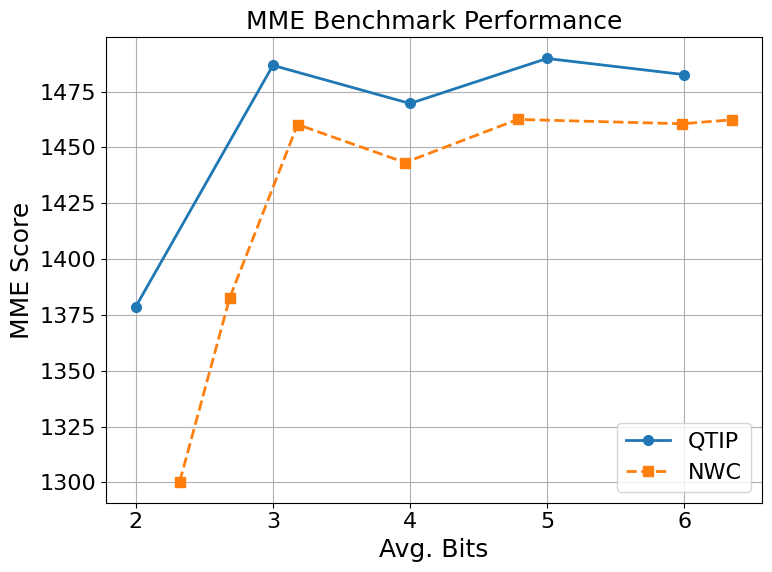

In [12]:
all_model_results = {}
all_model_results['Llava-1.5-7B'] = all_result

import matplotlib.cm as cm

plt.rcParams['font.size'] = 16
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.titlesize'] = 20
# 3. 그래프 생성
fig, ax = plt.subplots(figsize=(8, 6))

# 4. 각 커브(QTIP, NWC)를 그래프에 그리기
# QTIP 데이터 플롯
qtip_mme_data = all_result['QTIP']['MME']
ax.plot(qtip_mme_data['bits'], qtip_mme_data['score'], 
        label='QTIP', marker='o', linestyle='-', lw=2.0, ms=7)

# NWC 데이터 플롯
nwc_mme_data = all_result['NWC']['MME']
ax.plot(nwc_mme_data['bits'], nwc_mme_data['score'], 
        label='NWC', marker='s', linestyle='--', lw=2.0, ms=7)

# 5. 그래프 제목 및 라벨 설정
ax.set_title('MME Benchmark Performance')
ax.set_xlabel('Avg. Bits')
ax.set_ylabel('MME Score')

# 6. 범례, 그리드 추가 및 그래프 표시
ax.legend()
ax.grid(True)
plt.tight_layout() # 그래프 요소들이 겹치지 않게 조정
plt.show()

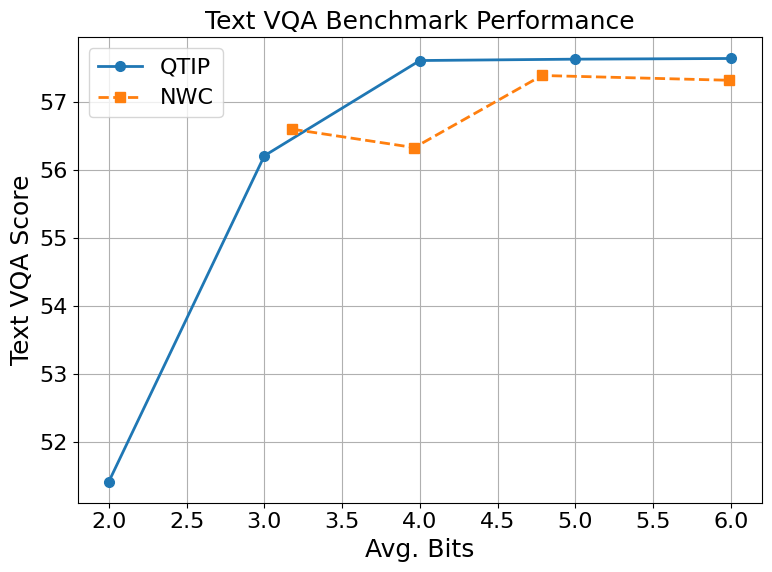

In [14]:
all_model_results = {}
all_model_results['Llava-1.5-7B'] = all_result

import matplotlib.cm as cm

plt.rcParams['font.size'] = 16
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.titlesize'] = 20
# 3. 그래프 생성
fig, ax = plt.subplots(figsize=(8, 6))

# 4. 각 커브(QTIP, NWC)를 그래프에 그리기
# QTIP 데이터 플롯
qtip_mme_data = all_result['QTIP']['Text VQA']
ax.plot(qtip_mme_data['bits'], qtip_mme_data['score'], 
        label='QTIP', marker='o', linestyle='-', lw=2.0, ms=7)

# NWC 데이터 플롯
nwc_mme_data = all_result['NWC']['Text VQA']
ax.plot(nwc_mme_data['bits'], nwc_mme_data['score'], 
        label='NWC', marker='s', linestyle='--', lw=2.0, ms=7)

# 5. 그래프 제목 및 라벨 설정
ax.set_title('Text VQA Benchmark Performance')
ax.set_xlabel('Avg. Bits')
ax.set_ylabel('Text VQA Score')

# 6. 범례, 그리드 추가 및 그래프 표시
ax.legend()
ax.grid(True)
plt.tight_layout() # 그래프 요소들이 겹치지 않게 조정
plt.show()

In [29]:
# import numpy as np
# import matplotlib.pyplot as plt

# # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

# # Plot 1: bit <= 4.5
# for model, model_data in plot_data.items():
#     bits = np.array(model_data['bit'])
#     top1s = np.array(model_data['top1'])
#     mask = bits <= 4.5
#     ax1.plot(bits[mask], top1s[mask], label=f'{model} Top1', marker='o')

# ax1.set_title('Bit ≤ 4.5')
# ax1.set_xlabel('Bit')
# ax1.set_ylabel('Imagenet Acc.')
# ax1.axhline(y=0.7121, color='r', linestyle='--', label='Top1')
# ax1.grid(True)
# ax1.legend()
# ax1.set_ylim(0.5, None)

# # Plot 2: bit > 4.5
# for model, model_data in plot_data.items():
#     bits = np.array(model_data['bit'])
#     top1s = np.array(model_data['top1'])
#     mask = bits > 4.5
#     ax2.plot(bits[mask], top1s[mask], label=f'{model} Top1', marker='o')

# ax2.set_title('Bit > 4.5')
# ax2.set_xlabel('Bit')
# ax2.axhline(y=0.7121, color='r', linestyle='--')
# ax2.grid(True)
# ax2.legend()
# ax2.set_ylim(None, None)

# plt.tight_layout()
# plt.show()
